In [20]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [21]:
df = pd.read_csv('./AllFeaturesDogMoveDataExtracted.csv')

# feature engineering

In [22]:
# calculate sum of standard deviation in 3 axes (per sensor)
df['Axyz_SD'] = (df['Ax_Standard deviation'] + df['Ay_Standard deviation'] + df['Ax_Standard deviation'])
df['Gxyz_SD'] = (df['Gx_Standard deviation'] + df['Gy_Standard deviation'] + df['Gx_Standard deviation'])

# mean value (3 axes, 2 sensor modalities = 6 total)
# already included in dataframe (one of the default features to be extracted by tsfel)

# sum of triaxial zero crossing rate for each sensor modality
df['Axyz_ZCR'] = df['Ax_Zero crossing rate'] + df['Ay_Zero crossing rate'] + df['Az_Zero crossing rate']
df['Gxyz_ZCR'] = df['Gx_Zero crossing rate'] + df['Gy_Zero crossing rate'] + df['Gz_Zero crossing rate']

In [23]:
for col in ['Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean']:
    df[col] = np.where(df[col] >= 0.5, 1, 0) # replace values >= 0.5 with 1, else 0 

In [24]:
# reverse dummy encoding behavior labels for plotting purposes. then rename 
df['Behavior'] = (df.iloc[:, -9:-5] == 1).idxmax(1)
df['Behavior'].replace({'Behavior_Moving_Mean':'Moving', 'Behavior_Lying_Mean':'Lying', 'Behavior_Sitting_Mean':'Sitting', 'Behavior_Standing_Mean':'Standing'}, inplace=True)

In [25]:
# before we move onto feature selection, we can remove any rows where behaviour = Standing. This label was included up to this point to enable to calculation of a mean of standing for each dog, which was a prerequsite for the calculation of the feature position offset (APO, GPO) 
# now that APO & GPO have been calculated and added to the dataframe, we can drop behavior=Standing rows 

df = df[~df['Behavior'].isin(['Standing'])] # drop rows where behavior == standing 

# feature selection from all (~60) features extracted by tsfel with default config
* univariate selection with ANOVA (f_classif)
* ExtraTreesClassifier 

In [26]:
# dummy encoded behaviour labels were needed for feature extraction but not for classification. hence we can drop them 
df.drop(columns=['Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean'], inplace=True)

In [27]:
y = df['Behavior']
x = df.iloc[:,:-2]

skb_model = SelectKBest(f_classif, k=14) # anova feature selection - modify k here 
skb_model.fit(x, y)

features = skb_model.fit_transform(x,y) # identify k best features 
skb_top_n_features_ind = skb_model.get_support(indices=True) # index these features 
fsel = x.iloc[:,skb_top_n_features_ind] 

features_ranked = pd.DataFrame({'col_name': skb_model.scores_}, index=x.columns).sort_values(by='col_name', ascending=False)
skb_top_n_features_ind

array([ 253,  396,  416,  422,  424,  425,  488,  631,  652,  655,  657,
        659,  958, 1193])

<AxesSubplot:title={'center':'ranked feature importance scores from SelectKBest ANOVA test'}>

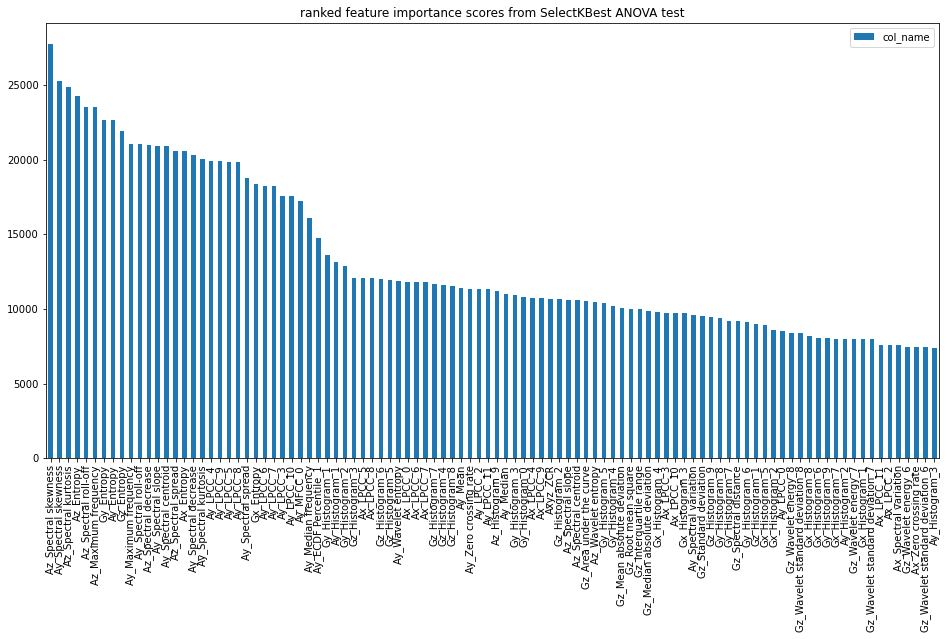

In [28]:
features_ranked.iloc[:100,:].plot(kind='bar', figsize=(16,8), title='ranked feature importance scores from SelectKBest ANOVA test')
# diminishing returns after k=9, k=22, k=34

In [29]:
y = df['Behavior']
x = df.iloc[:,:-2]

# feature selection with extra trees classifier 
etc_model = ExtraTreesClassifier(n_estimators=100)
etc_model.fit(x, y)

features_ranked = pd.DataFrame({'col_name': etc_model.feature_importances_}, index=x.columns).sort_values(by='col_name', ascending=False)

etc_top_n_features = features_ranked.iloc[:5,:] # modify n here 
cols = list(etc_top_n_features.index.values) 
etc_top_n_features_ind = [df.columns.get_loc(c) for c in cols if c in df]

<AxesSubplot:title={'center':'ranked feature importance scores from ExtraTreesClassifier'}>

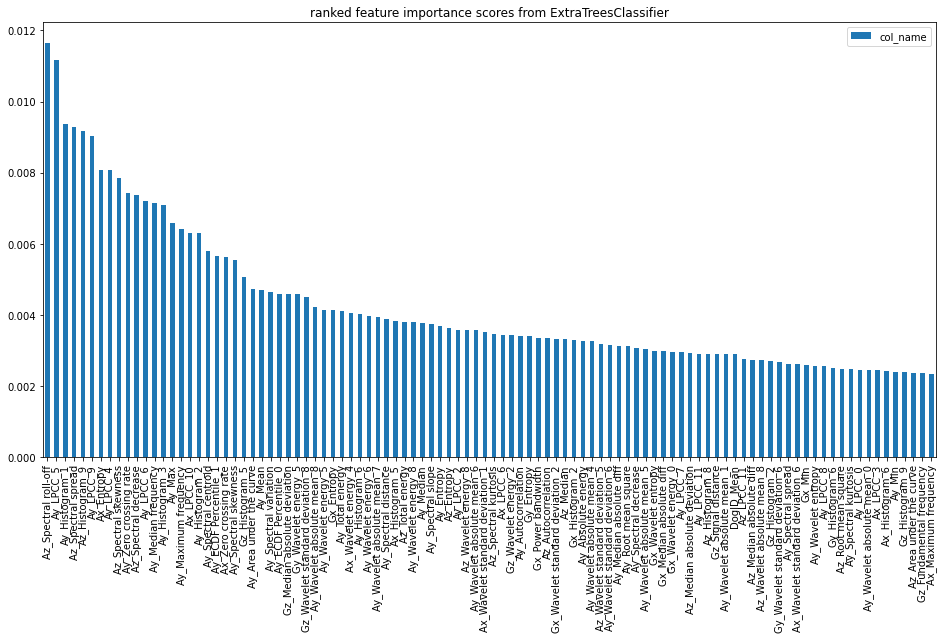

In [30]:
features_ranked.iloc[:100, :].plot(kind='bar', figsize=(16,8), title='ranked feature importance scores from ExtraTreesClassifier')
# diminishing returns after 5th, 10th feature 

In [31]:
x_top_n = df.iloc[:,etc_top_n_features_ind] # modify feature selection algorithm here 
y = df['Behavior']

*FEATURE SELECTED (X_TOP_N) DATA IS NORMALISED BELOW AND REASSIGNED = X_TOP_N_NORM*

In [32]:
# feature normalisation 
scaler = preprocessing.StandardScaler()
x_top_n_norm = scaler.fit_transform(x_top_n)

# model building!  
* simple train_test_split for preliminary model building
* followed by leave-one-group-out cross-validation (dog-wise) 

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_top_n_norm, y, test_size=0.2)

* Kumpulainena et al., (2021) used four models:
    * linear and quadratic discriminant analysis classifiers (LDA and QDA, respectively)
    * support vector machine (SVM) classifier with gaussian kernel 
    * a classification (decision) tree
* regarding evaluation metrics for the models, we will use the following:
    * f1 score - robust evaluation method, useful where there is a class imbalance as is present here
    * confusion matrix - indicates false positives and false negatives 

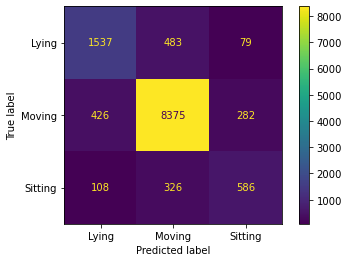

accuracy = 0.8603507621701361
f1-score = [0.73717026 0.91695407 0.59583122]


              precision    recall  f1-score   support

       Lying       0.74      0.73      0.74      2099
      Moving       0.91      0.92      0.92      9083
     Sitting       0.62      0.57      0.60      1020

    accuracy                           0.86     12202
   macro avg       0.76      0.74      0.75     12202
weighted avg       0.86      0.86      0.86     12202



In [34]:
# training a DescisionTreeClassifier
dtc_model = DecisionTreeClassifier(max_depth = 18).fit(x_train, y_train)
dtc_preds = dtc_model.predict(x_test)

# accuracy score  
accuracy = dtc_model.score(x_test, y_test)

# creating a confusion matrix
cm = confusion_matrix(y_test, dtc_preds, labels=dtc_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20)=0.815 // etc_model(9)=0.811 // skb_model(14)=0.803 - custom features 
                                # etc_model(5)=0.858 - default features 
print(f'f1-score = {f1_score(y_test, dtc_preds, average=None)}')
print('\n')
print(classification_report(y_test, dtc_preds, target_names=dtc_model.classes_))

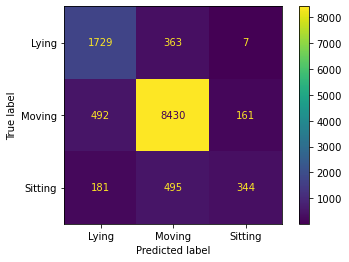

accuracy = 0.8607605310604819
f1-score = [0.76827372 0.9177508  0.44908616]


              precision    recall  f1-score   support

       Lying       0.72      0.82      0.77      2099
      Moving       0.91      0.93      0.92      9083
     Sitting       0.67      0.34      0.45      1020

    accuracy                           0.86     12202
   macro avg       0.77      0.70      0.71     12202
weighted avg       0.86      0.86      0.85     12202



In [35]:
# support vector classifier 
svc_model = SVC(kernel = 'linear', C = 1).fit(x_train, y_train)
svc_preds = svc_model.predict(x_test)
 
# model accuracy for x_test 
accuracy = svc_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, svc_preds, labels=svc_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.843 // etc_model(9)=0.817 // skb_model(14)=0.838 - custom features 
                                # etc_model(5)=0.838 - default features 
print(f'f1-score = {f1_score(y_test, svc_preds, average=None)}')
print('\n')
print(classification_report(y_test, svc_preds, target_names=svc_model.classes_))

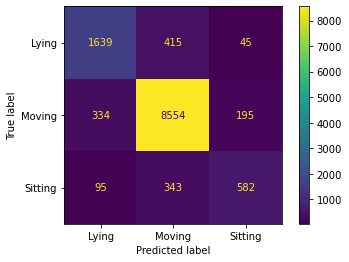

accuracy = 0.8830519586952958
f1-score = [0.78665707 0.93003534 0.63192182]


              precision    recall  f1-score   support

       Lying       0.79      0.78      0.79      2099
      Moving       0.92      0.94      0.93      9083
     Sitting       0.71      0.57      0.63      1020

    accuracy                           0.88     12202
   macro avg       0.81      0.76      0.78     12202
weighted avg       0.88      0.88      0.88     12202



In [36]:
# k nearest neighbours
knn_model = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)
knn_preds = knn_model.predict(x_test) 

# accuracy on x_test
accuracy = knn_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, knn_preds, labels=knn_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.959 // etc_model(9)=0.946 // skb_model(14)=0.938 - custom features 
                                # etc_model(5)=0.938 - default features 
print(f'f1-score = {f1_score(y_test, knn_preds, average=None)}')
print('\n')
print(classification_report(y_test, knn_preds, target_names=knn_model.classes_))

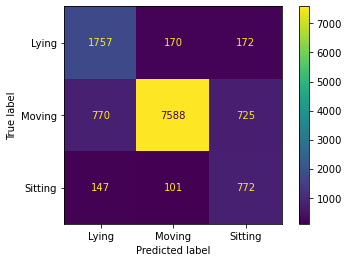

accuracy = 0.8291263727257827
f1-score = [0.7362246  0.89576201 0.57419115]


              precision    recall  f1-score   support

       Lying       0.66      0.84      0.74      2099
      Moving       0.97      0.84      0.90      9083
     Sitting       0.46      0.76      0.57      1020

    accuracy                           0.83     12202
   macro avg       0.70      0.81      0.74     12202
weighted avg       0.87      0.83      0.84     12202



In [37]:
# naive bayes (gaussian)
gnb_model = GaussianNB().fit(x_train, y_train)
gnb_preds = gnb_model.predict(x_test)
 
# accuracy on x_test
accuracy = gnb_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_preds, labels=gnb_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.803 // etc_model(9)=0.799 // skb_model(14)=0.820 - custom features 
                                # etc_model(5)=0.820 - default features 
print(f'f1-score = {f1_score(y_test, gnb_preds, average=None)}')
print('\n')
print(classification_report(y_test, gnb_preds, target_names=gnb_model.classes_))

# leave one group out cross-validation (LOGOCV)
* leave one group out approach abrogates subject bias
* k-nearest neighbours model had best accuracy scores using random train_test_split (~0.94)
* mean accuracy scores for the 4 models when tested with LOGOCV are lower across the board 
    * greater variation between test-group and train-group size in LOGOCV when compared to train_test_split 
    

In [38]:
groups = df['DogID_Mean'].values
logo = LeaveOneGroupOut()
logo.get_n_splits(x_top_n_norm, y, groups=groups) # verify that there is a split for each dog (total 45) 
logocv_accuracy = []

for train_ind, test_ind in logo.split(x_top_n_norm, y, groups=groups):
    x_top_n_norm_train = x_top_n_norm[train_ind]
    x_top_n_norm_test = x_top_n_norm[test_ind]
    y_train = y.iloc[train_ind]
    y_test = y.iloc[test_ind]

    # build model 
    svc_model = KNeighborsClassifier(n_neighbors = 7).fit(x_top_n_norm_train, y_train)
    svc_preds = knn_model.predict(x_top_n_norm_test) 

    # record accuracy 
    accuracy = knn_model.score(x_top_n_norm_test, y_test)
    logocv_accuracy.append(accuracy)

print(sum(logocv_accuracy) / len(logocv_accuracy))

0.8976842504074553


In [39]:
groups = df['DogID_Mean'].values
logo = LeaveOneGroupOut()
logo.get_n_splits(x_top_n_norm, y, groups=groups) # verify that there is a split for each dog (total 45) 
logocv_accuracy = []

for train_ind, test_ind in logo.split(x_top_n_norm, y, groups=groups):
    x_top_n_norm_train = x_top_n_norm[train_ind]
    x_top_n_norm_test = x_top_n_norm[test_ind]
    y_train = y.iloc[train_ind]
    y_test = y.iloc[test_ind]

   # support vector classifier 
    svc_model = SVC(kernel = 'linear', C = 1).fit(x_top_n_norm_train, y_train)
    svc_preds = svc_model.predict(x_top_n_norm_test)
    
    # model accuracy for x_test 
    accuracy = svc_model.score(x_top_n_norm_test, y_test)
    logocv_accuracy.append(accuracy)

print(sum(logocv_accuracy) / len(logocv_accuracy))

0.8502635883435932


In [40]:
groups = df['DogID_Mean'].values
logo = LeaveOneGroupOut()
logo.get_n_splits(x_top_n_norm, y, groups=groups) # verify that there is a split for each dog (total 45) 
logocv_accuracy = []

for train_ind, test_ind in logo.split(x_top_n_norm, y, groups=groups):
    x_top_n_norm_train = x_top_n_norm[train_ind]
    x_top_n_norm_test = x_top_n_norm[test_ind]
    y_train = y.iloc[train_ind]
    y_test = y.iloc[test_ind]

    gnb_model = DecisionTreeClassifier(max_depth = 18).fit(x_top_n_norm_train, y_train)
    gnb_preds = dtc_model.predict(x_top_n_norm_test)

   
    # model accuracy for x_test 
    accuracy = dtc_model.score(x_top_n_norm_test, y_test)
    logocv_accuracy.append(accuracy)

print(sum(logocv_accuracy) / len(logocv_accuracy))

0.9443483543300755


In [41]:
groups = df['DogID_Mean'].values
logo = LeaveOneGroupOut()
logo.get_n_splits(x_top_n_norm, y, groups=groups) # verify that there is a split for each dog (total 45) 
logocv_accuracy = []

for train_ind, test_ind in logo.split(x_top_n_norm, y, groups=groups):
    x_top_n_norm_train = x_top_n_norm[train_ind]
    x_top_n_norm_test = x_top_n_norm[test_ind]
    y_train = y.iloc[train_ind]
    y_test = y.iloc[test_ind]

    gnb_model = GaussianNB().fit(x_top_n_norm_train, y_train)
    gnb_preds = gnb_model.predict(x_top_n_norm_test)

   
    # model accuracy for x_test 
    accuracy = gnb_model.score(x_top_n_norm_test, y_test)
    logocv_accuracy.append(accuracy)

print(sum(logocv_accuracy) / len(logocv_accuracy))

0.8152531143255285
